In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import ensemble
from sklearn.model_selection import train_test_split , RandomizedSearchCV , StratifiedShuffleSplit
import xgboost as xgb

In [2]:
movies = pd.read_csv('Dataset/movies.dat', sep = '::', engine='python',
                     names=['MovieID','Title','Genres'],index_col ='MovieID' )
users = pd.read_csv('Dataset/users.dat', sep = '::', engine='python',
                     names=['UserID','Gender','Age','Occupation','Zip-code'],index_col ='UserID' )
ratings = pd.read_csv('Dataset/ratings.dat', sep = '::', engine='python',
                     names=['UserID','MovieID','Rating','Timestamp'])#,index_col =['UserID','MovieID'] )
movies.shape , users.shape , ratings.shape
movies.head() , users.head() , ratings.head()

(                                      Title                        Genres
 MovieID                                                                  
 1                          Toy Story (1995)   Animation|Children's|Comedy
 2                            Jumanji (1995)  Adventure|Children's|Fantasy
 3                   Grumpier Old Men (1995)                Comedy|Romance
 4                  Waiting to Exhale (1995)                  Comedy|Drama
 5        Father of the Bride Part II (1995)                        Comedy,
        Gender  Age  Occupation Zip-code
 UserID                                 
 1           F    1          10    48067
 2           M   56          16    70072
 3           M   25          15    55117
 4           M   45           7    02460
 5           M   25          20    55455,
    UserID  MovieID  Rating  Timestamp
 0       1     1193       5  978300760
 1       1      661       3  978302109
 2       1      914       3  978301968
 3       1     3408       4  9

# Data Wrangling

In [3]:
users_ratings_df = pd.merge(users,ratings,how='inner',on='UserID')
users_ratings_movies_df = pd.merge(users_ratings_df,movies,how='inner',on='MovieID')
users_ratings_movies_df = users_ratings_movies_df[['UserID','Gender','Age','Occupation','Rating','MovieID','Title','Timestamp']]
age_group_dict = { 1:  "Under 18",18:  "18-24",25:  "25-34",35:  "35-44",45:  "45-49",50:  "50-55",56:  "56+"}

occupation_dict = {  0:  "other or not specified",1:  "academic/educator",2:  "artist",3:  "clerical/admin",
                   4:  "college/grad student",5:  "customer service",6:  "doctor/health care",7:  "executive/managerial",
                   8:  "farmer",9:  "homemaker",10:  "K-12 student",11:  "lawyer",12:  "programmer",13:  "retired",
                   14:  "sales/marketing",15:  "scientist",16:  "self-employed",17:  "technician/engineer",
                   18:  "tradesman/craftsman",19:  "unemployed",20:  "writer"}

users_ratings_movies_df['Age'] = users_ratings_movies_df['Age'].map(age_group_dict)
users_ratings_movies_df['Occupation'] = users_ratings_movies_df['Occupation'].map(occupation_dict)

#Extract just year from timestamp column
users_ratings_movies_df=users_ratings_movies_df.rename(columns = {'Timestamp':'Year'})
users_ratings_movies_df['Year'] = [datetime.fromtimestamp(timestamp).year for timestamp in users_ratings_movies_df['Year'] ] 

users_ratings_movies_df = pd.merge(users_ratings_movies_df,movies[['Genres']],how='inner',on='MovieID')

users_ratings_movies_df.head()

,UserID,Gender,Age,Occupation,Rating,MovieID,Title,Year,Genres
0,1,F,Under 18,K-12 student,5,1193,One Flew Over the Cuckoo's Nest (1975),2000,Drama
1,2,M,56+,self-employed,5,1193,One Flew Over the Cuckoo's Nest (1975),2000,Drama
2,12,M,25-34,programmer,4,1193,One Flew Over the Cuckoo's Nest (1975),2000,Drama
3,15,M,25-34,executive/managerial,4,1193,One Flew Over the Cuckoo's Nest (1975),2000,Drama
4,17,M,50-55,academic/educator,5,1193,One Flew Over the Cuckoo's Nest (1975),2000,Drama


In [4]:
# Seperate all genre to movie_genres_df dataframe
movie_genres_df = pd.DataFrame(columns=['MovieID','Genre'])
for index,movie in movies.iterrows():
    for genre in movie['Genres'].split('|'):
        movie_genres_df = movie_genres_df.append({'MovieID' : index , 'Genre': genre},ignore_index=True)

movie_genres_df.Genre.unique()
type(movie_genres_df.Genre)

pandas.core.series.Series

**Data Sampling(1% of Data)**

In [5]:
# 1% sample of items
df = users_ratings_movies_df.sample(frac=0.01)
df.head()

,UserID,Gender,Age,Occupation,Rating,MovieID,Title,Year,Genres
751406,1264,M,25-34,academic/educator,4,125,Flirting With Disaster (1996),2000,Comedy
625250,3879,M,25-34,clerical/admin,3,2369,Desperately Seeking Susan (1985),2000,Comedy|Romance
648475,2181,M,25-34,other or not specified,2,2613,Night of the Comet (1984),2000,Action|Horror|Sci-Fi
891912,1448,F,25-34,clerical/admin,3,100,City Hall (1996),2000,Drama|Thriller
967453,4875,M,35-44,other or not specified,5,759,Maya Lin: A Strong Clear Vision (1994),2000,Documentary


In [6]:
def belongs_to_genre (genres,genre):
    if genres.__contains__(genre) :
        return 1
    return 0

In [7]:
for genre in movie_genres_df.Genre.iteritems() :
    df[genre[1]] = df.apply(lambda row: belongs_to_genre(row.Genres,genre[1]), axis = 1)

In [8]:
df = df.drop(['Genres'], 1)
df.head(10)

,UserID,Gender,Age,Occupation,Rating,MovieID,Title,Year,Animation,Children's,...,Crime,Thriller,Horror,Sci-Fi,Documentary,War,Musical,Mystery,Film-Noir,Western
751406,1264,M,25-34,academic/educator,4,125,Flirting With Disaster (1996),2000,0,0,...,0,0,0,0,0,0,0,0,0,0
625250,3879,M,25-34,clerical/admin,3,2369,Desperately Seeking Susan (1985),2000,0,0,...,0,0,0,0,0,0,0,0,0,0
648475,2181,M,25-34,other or not specified,2,2613,Night of the Comet (1984),2000,0,0,...,0,0,1,1,0,0,0,0,0,0
891912,1448,F,25-34,clerical/admin,3,100,City Hall (1996),2000,0,0,...,0,1,0,0,0,0,0,0,0,0
967453,4875,M,35-44,other or not specified,5,759,Maya Lin: A Strong Clear Vision (1994),2000,0,0,...,0,0,0,0,1,0,0,0,0,0
599224,3132,M,35-44,executive/managerial,4,3535,American Psycho (2000),2000,0,0,...,0,1,1,0,0,0,0,0,0,0
108606,2670,M,35-44,doctor/health care,4,2858,American Beauty (1999),2000,0,0,...,0,0,0,0,0,0,0,0,0,0
339381,8,M,25-34,programmer,4,266,Legends of the Fall (1994),2000,0,0,...,0,0,0,0,0,1,0,0,0,1
120487,1699,F,25-34,unemployed,5,1265,Groundhog Day (1993),2000,0,0,...,0,0,0,0,0,0,0,0,0,0
315529,4932,M,25-34,executive/managerial,4,1966,Metropolitan (1990),2000,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10002 entries, 751406 to 778991
Data columns (total 26 columns):
UserID         10002 non-null int64
Gender         10002 non-null object
Age            10002 non-null object
Occupation     10002 non-null object
Rating         10002 non-null int64
MovieID        10002 non-null int64
Title          10002 non-null object
Year           10002 non-null int64
Animation      10002 non-null int64
Children's     10002 non-null int64
Comedy         10002 non-null int64
Adventure      10002 non-null int64
Fantasy        10002 non-null int64
Romance        10002 non-null int64
Drama          10002 non-null int64
Action         10002 non-null int64
Crime          10002 non-null int64
Thriller       10002 non-null int64
Horror         10002 non-null int64
Sci-Fi         10002 non-null int64
Documentary    10002 non-null int64
War            10002 non-null int64
Musical        10002 non-null int64
Mystery        10002 non-null int64
Film-Noir      10

In [11]:
df.select_dtypes(include=['object']).columns

Index(['Gender', 'Age', 'Occupation', 'Title'], dtype='object')

In [12]:
# Object data to category
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype('category')
    
# Encoding categorical features
for col in df.select_dtypes(include=['category']).columns:
    df[col] = df[col].cat.codes

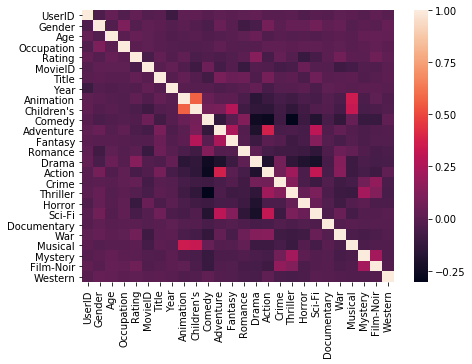

In [13]:
# Сorrelation matrix
plt.figure(figsize=[7,5])
sns.heatmap(df.corr())
plt.show()

# Random Forest

In [14]:
model = ensemble.RandomForestClassifier(n_estimators=250, max_depth=25)
model.fit(df[df.columns[df.columns != 'Rating']], df.Rating)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=25, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [15]:
df_plot = pd.DataFrame({'features': df.columns[df.columns != 'Rating'],
                        'importances': model.feature_importances_})
df_plot = df_plot.sort_values('importances', ascending=False)

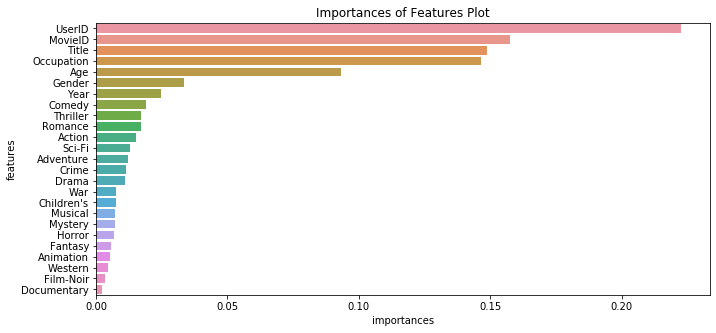

In [16]:
plt.figure(figsize=[11,5])
sns.barplot(x = df_plot.importances, y = df_plot.features)
plt.title('Importances of Features Plot')
plt.show()

**I selected the most informative columns using Random Forest Model.**

In [17]:
informative_columns = df.drop(df_plot.features[df_plot.importances < 0.05].tolist(), 1).columns
informative_columns

Index(['UserID', 'Age', 'Occupation', 'Rating', 'MovieID', 'Title'], dtype='object')

**Now we select informative columns from whole data.**

In [18]:
df_informative = users_ratings_movies_df[informative_columns]
df_informative.head()

,UserID,Age,Occupation,Rating,MovieID,Title
0,1,Under 18,K-12 student,5,1193,One Flew Over the Cuckoo's Nest (1975)
1,2,56+,self-employed,5,1193,One Flew Over the Cuckoo's Nest (1975)
2,12,25-34,programmer,4,1193,One Flew Over the Cuckoo's Nest (1975)
3,15,25-34,executive/managerial,4,1193,One Flew Over the Cuckoo's Nest (1975)
4,17,50-55,academic/educator,5,1193,One Flew Over the Cuckoo's Nest (1975)


# XGboost

In [19]:
# Train & Test split
target = df_informative.pop('Rating')
train_data, test_data, train_labels, test_labels = train_test_split(df_informative, target, test_size = 0.3)

It seems like new version of xgboost do not accept the datatype of in fields Age, Occupation, Title since they are objects.So I convert them.

In [20]:
from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()
train_data['Age'] = lbl.fit_transform(train_data['Age'].astype(str))
train_data['Occupation'] = lbl.fit_transform(train_data['Occupation'].astype(str))
train_data['Title'] = lbl.fit_transform(train_data['Title'].astype(str))

test_data['Age'] = lbl.fit_transform(test_data['Age'].astype(str))
test_data['Occupation'] = lbl.fit_transform(test_data['Occupation'].astype(str))
test_data['Title'] = lbl.fit_transform(test_data['Title'].astype(str))

C:\Users\Amin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Amin\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Amin\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

**Parameters Tuning**

In [33]:
# Create model

model = xgb.XGBClassifier()

# Create parameters grid

parameters_grid = { 'learning_rate' : [0.1, 0.2, 0.5], 'max_depth' : [5, 10, 15], 'n_estimators' : [150, 250, 300], 'min_child_weight' : [3, 5, 10] }

# Strategy of cross validation

cv = StratifiedShuffleSplit(n_splits = 3, test_size = 0.3)

# Create Grid search Strategy

grid_cv = RandomizedSearchCV(model, parameters_grid, scoring = 'accuracy', cv = cv)

# Fit model by Grid

grid_cv.fit(train_data, train_labels)

# Model with the best estimator

grid_cv.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=10,
              min_child_weight=10, missing=None, n_estimators=250, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [34]:
model = xgb.XGBClassifier(learning_rate=0.2, max_depth=10, min_child_weight=10, n_estimators=250)
model.fit(train_data, train_labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=10,
              min_child_weight=10, missing=None, n_estimators=250, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [35]:
# Predicting
predict_labels = model.predict(test_data)

# The results of the algorithm

In [36]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, predict_labels))

              precision    recall  f1-score   support

           1       0.48      0.17      0.25     16813
           2       0.32      0.07      0.11     32553
           3       0.38      0.36      0.37     78291
           4       0.41      0.66      0.51    104278
           5       0.51      0.33      0.40     68128

    accuracy                           0.42    300063
   macro avg       0.42      0.32      0.33    300063
weighted avg       0.42      0.42      0.39    300063

